In [41]:
%matplotlib notebook
# import mpld3
# mpld3.enable_notebook()

import pandas as pd
import os
import re
import sys
from pprint import pprint
import matplotlib.pyplot as plt
from math import *

from cycler import cycler

import json_lines # https://github.com/TeamHG-Memex/json-lines

from IPython.display import display, HTML

plt.ion()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.rcParams['figure.figsize'] = [10, 8]

In [211]:
def load_results(path, filename_regex, index='iteration'):
    files = [f for f in os.listdir(path) if re.match(filename_regex, f)]
    print(files)
#     pprint(os.listdir(path))

    aggregated_columns = {}
    data_sets = []
    for f in files:
        print('file', f)
        
        rows = []
        with open(f, 'rb') as file:
            rows = [row for row in json_lines.reader(file)]
            
        columns = rows[0]
        data = rows[1:]
        print('columns: ', columns)
        df = pd.DataFrame(data, columns=columns)
        df.set_index(index, inplace=True)
        data_sets.append(df)
        
        for col_name in columns:
            if col_name not in aggregated_columns:
                aggregated_columns[col_name] = pd.DataFrame()
    
    
    for col_name, aggregation in aggregated_columns.items():
        for i, data_set in enumerate(data_sets):
            if col_name in data_set:
                aggregation[i] = data_set[col_name]
    
#     for df in data_sets:
#         display(HTML(df.to_html()))
    
#     for col_name, aggregation in tuple(aggregated_columns.items()):
#         display(HTML(aggregation.to_html()))

    return (data_sets, aggregated_columns)
    

def smooth_aggregated_column(aggregated_column, window_size):
    print('ws ', window_size)
    return aggregated_column.rolling(window=window_size,axis=0).mean()

In [185]:
colors = [
    (0.0,0.0,1.0),
    (0.0,1.0,0.0),
    (1.0,0.0,0.0),
    (0.0,0.7,0.7),
    (0.7,0.7,0.0),
    (0.0,0.0,0.0),
    (0.5,0.5,0.5),
]

def plot_quantiles(x, aggregated_column, color=(0,0,.8), alpha=.15, range=.667):
    plt.plot(x, aggregated_column.quantile(.5, 1), color=color)
    q1 = aggregated_column.quantile(.5+range/2, 1).values.tolist()
    q2 = aggregated_column.quantile(.5-range/2, 1).values.tolist()
    plt.fill_between(x, q1, q2, color=(*color, alpha))

def plot_smooth_quantiles(x, aggregated_column, window_size=5, **kwargs):
    plot_quantiles(x, smooth_aggregated_column(aggregated_column, window_size), **kwargs)
    
def normalize_sequence(seq):
    hi = max(seq)
    lo = min(seq)
    scale = max(1e-6, hi - lo)
    return [(x-lo) / scale for x in seq]

def plot_perf(acols, color):
    evals = acols['num_evaluations'].median(1)
    iters = acols['score'].index
    plot_quantiles(evals, acols['score'])
    plt.ylabel('solution score')
    plt.xlabel('# of evaluations')

In [212]:
data_sets, acols = load_results('/home/ctripp/project/hybrid_systems/examples/', r'test_run.*\.jsonl')

['test_run_wind_opt_dce_bgmd_15802344026259.jsonl', 'test_run_wind_opt_dce_bgmd_15802463795967.jsonl', 'test_run_wind_opt_dce_bgmd_15802361706633.jsonl']
file test_run_wind_opt_dce_bgmd_15802344026259.jsonl
columns:  ['generation', 'population', 'iteration', 'num_evaluations', 'score', 'best_solution']
file test_run_wind_opt_dce_bgmd_15802463795967.jsonl
columns:  ['generation', 'population', 'iteration', 'num_evaluations', 'score', 'best_solution']
file test_run_wind_opt_dce_bgmd_15802361706633.jsonl
columns:  ['generation', 'population', 'iteration', 'num_evaluations', 'score', 'best_solution']


<IPython.core.display.Javascript object>


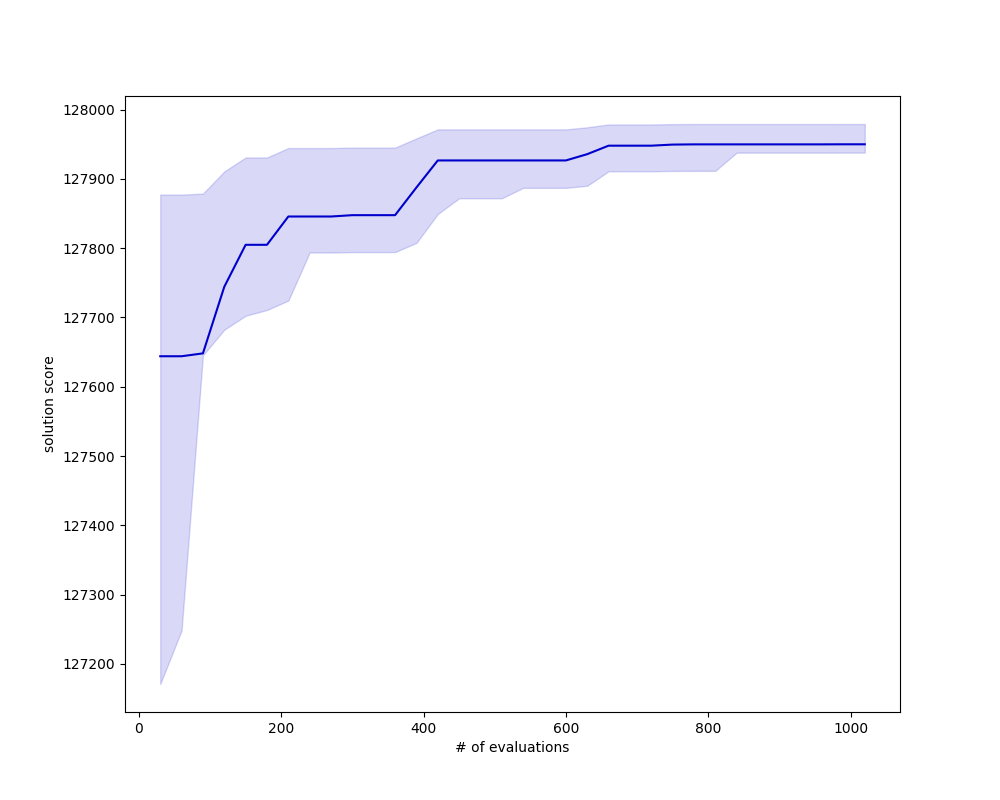

In [234]:
# plot_quantiles(acols['score'].index, acols['score'])
plt.figure()
plot_perf(acols, colors[0])

<IPython.core.display.Javascript object>


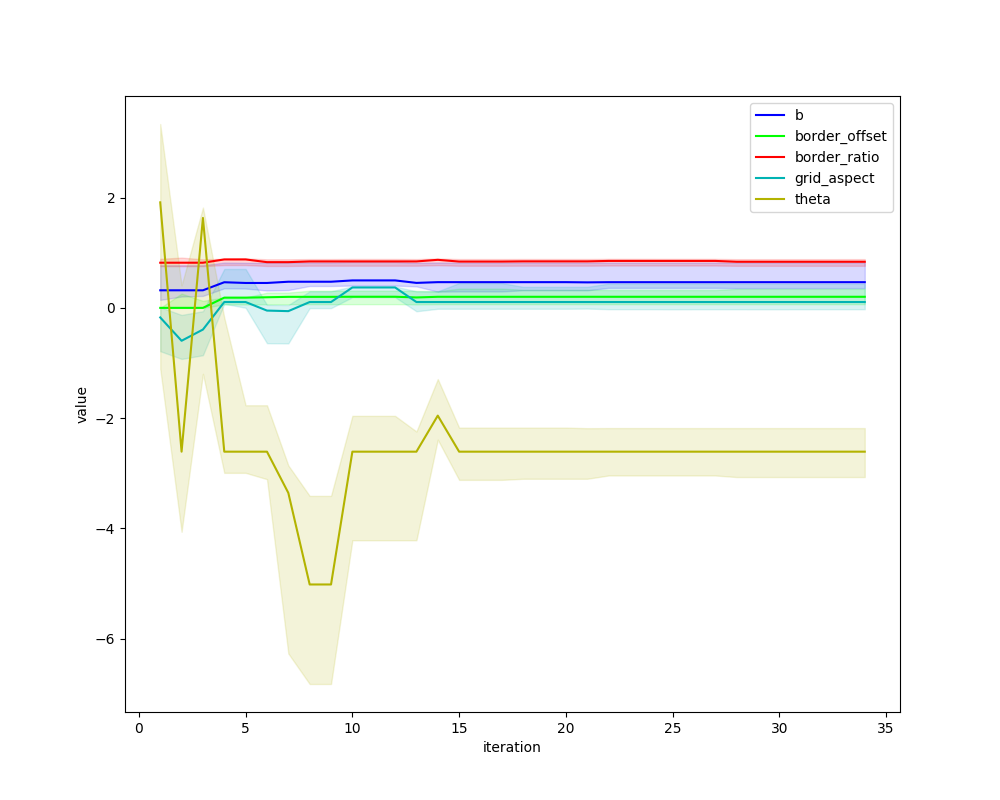

Text(0, 0.5, 'value')

In [238]:

def extract_solution_vars(aggregated_col, index='iteration', aggregation={}, prefix=''):
    solution_vars = sorted(acols['best_solution'].iloc[0][0].keys())
    for var in solution_vars:
        df = pd.DataFrame(index=aggregated_col.index)
        for run in aggregated_col.columns:
            col = aggregated_col[run]
            df[run] = [row[var] for row in col]
        aggregation[prefix+var] = df
    return solution_vars, aggregation

solution_vars, acols = extract_solution_vars(acols['best_solution'], aggregation=acols, prefix='best_solution.')

iters = acols['score'].index
plt.figure()
for i, var in enumerate(solution_vars):
    plot_quantiles(iters, acols['best_solution.' + var], color=colors[i%len(colors)])
plt.legend(solution_vars)
plt.xlabel('iteration')
plt.ylabel('value')